# Efficient Duplicate Detection with Embeddings and FAISS

Embeddings are numerical representations of data, such as text, that capture semantic meaning in a dense vector space. By leveraging embeddings, we can efficiently compare and analyze data points based on their contextual similarity. In this notebook, we utilize embeddings generated by state-of-the-art models from the SentenceTransformers library to deduplicate textual data. FAISS, a library optimized for similarity search, enables us to perform fast and scalable nearest neighbor searches on these embeddings, making it ideal for large datasets. This approach ensures high accuracy in identifying duplicates while maintaining computational efficiency.

In [1]:
import os
import sys
from typing import List
from types import SimpleNamespace

ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

import faiss
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

from utils import *

/Users/michalszczygiel/workspace/dupli-gone/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = prepare_dataset()

Loading datasets: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


In [3]:
texts = df['abstract'].to_list()
labels = df['label'].to_list()

In [ ]:
class EmbeddingDeduplicator:
    '''
    A class to deduplicate text embeddings using FAISS.
    '''
    def __init__(self, model_name: str = 'sentence-transformers/all-MiniLM-L6-v2', dimension: int = 384, top_k: int = 3, threshold: float = 0.85):
        self.model = SentenceTransformer(model_name, cache_folder='.cache')
        self.dimension = dimension
        self.top_k = top_k
        self.threshold = threshold
    
    def predict(self, texts: List[str]) -> np.ndarray:
        embeddings = self.model.encode(texts, show_progress_bar=False, normalize_embeddings=True)
        
        index = faiss.IndexFlatIP(self.dimension)
        index.add(embeddings)

        similarities, neighbors = index.search(embeddings, self.top_k)

        duplicates = set()

        for i in range(len(texts)):
            for j, sim in zip(neighbors[i][1:], similarities[i][1:]):
                if sim > self.threshold:
                        duplicates.add(i)
                        duplicates.add(j)

        indices = np.zeros(len(texts), dtype=int)
        indices[list(duplicates)] = 1
        return indices

## Ablation Study: Impact of Embedding Models on Deduplication Performance

The models below are sourced from the [original SentenceTransformers models](https://sbert.net/docs/sentence_transformer/pretrained_models.html#original-models).

| Model | Accuracy | Precision | Recall | F1 Score | Prediction Time (s) |
|-------|----------|-----------|--------|----------|----------------------|
| sentence-transformers/all-MiniLM-L12-v2    | 0.92823   | 0.96335    | 0.89033 | 0.92540   | 19.54994                |
| sentence-transformers/multi-qa-distilbert-cos-v1    | 0.95550   | 0.97380    | 0.93619 | 0.95462   | 107.48424                |
| sentence-transformers/all-MiniLM-L6-v2    | 0.94592   | 0.96905    | 0.92126 | 0.94455   | 22.15212                |
| sentence-transformers/multi-qa-MiniLM-L6-cos-v1    | 0.97204   | 0.97487    | 0.96907 | 0.97196   | 48.73280                |
| sentence-transformers/paraphrase-albert-small-v2    | 0.92310   | 0.97754    | 0.86610 | 0.91845   | 27.69109                |
| sentence-transformers/paraphrase-MiniLM-L3-v2    | 0.92860   | 0.97940    | 0.87562 | 0.92461   | 6.62277                |


In [ ]:
models = [
    SimpleNamespace(name='sentence-transformers/all-MiniLM-L12-v2', dimension=384),
    SimpleNamespace(name='sentence-transformers/multi-qa-distilbert-cos-v1', dimension=768),
    SimpleNamespace(name='sentence-transformers/all-MiniLM-L6-v2', dimension=384),
    SimpleNamespace(name='sentence-transformers/multi-qa-MiniLM-L6-cos-v1', dimension=384),
    SimpleNamespace(name='sentence-transformers/paraphrase-albert-small-v2', dimension=768),
    SimpleNamespace(name='sentence-transformers/paraphrase-MiniLM-L3-v2', dimension=384),
]

for model in models:
    print(f'Evaluating model: {model}')
    deduplicator = EmbeddingDeduplicator(model_name=model.name, dimension=model.dimension, threshold=0.95, top_k=3)
    benchmark = Benchmark(deduplicator)
    benchmark.evaluate(texts, labels, verbose=True)
    print('\n')

Evaluating model: namespace(name='sentence-transformers/all-MiniLM-L12-v2', dimension=384)
Summary:
Metric                        Value
-----------------------------------
Accuracy                    0.92823
Precision                   0.96335
Recall                      0.89033
F1                          0.92540
Prediction_time_sec        19.54994
Samples                  9347.00000
Duplicates               4623.00000


Evaluating model: namespace(name='sentence-transformers/multi-qa-distilbert-cos-v1', dimension=768)
Summary:
Metric                        Value
-----------------------------------
Accuracy                    0.95550
Precision                   0.97380
Recall                      0.93619
F1                          0.95462
Prediction_time_sec       107.48424
Samples                  9347.00000
Duplicates               4623.00000


Evaluating model: namespace(name='sentence-transformers/all-MiniLM-L6-v2', dimension=384)
Summary:
Metric                        Value
----

## Ablation Study: Sensitivity to Threshold

Since model **sentence-transformers/paraphrase-MiniLM-L3-v2** achieved the fastest prediction time among all evaluated models, all subsequent experiments in this study will be conducted using this model.

In [18]:
thresholds = np.linspace(0.80, 1.00, 11)  # [0.80, 0.82, ..., 1.00]

results = []

for threshold in tqdm(thresholds, desc=f'Processing thresholds'):
    deduplicator = EmbeddingDeduplicator(
        model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
        dimension=384,
        threshold=threshold,
        top_k=3
    )
    benchmark = Benchmark(deduplicator)
    metrics = benchmark.evaluate(texts, labels, verbose=False)
    results.append(metrics['accuracy'])

Processing thresholds: 100%|██████████| 11/11 [01:40<00:00,  9.16s/it]


/var/folders/2y/vxc21f554ng3_y3tbvy3892r0000gn/T/ipykernel_9051/1814682704.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


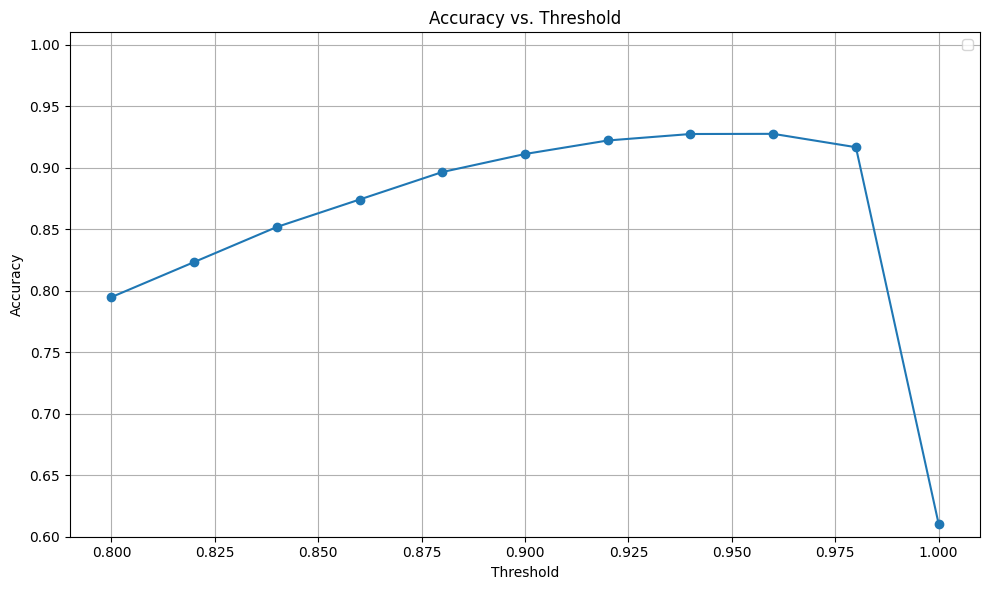

In [19]:
plt.figure(figsize=(10, 6))

plt.plot(thresholds, results, marker='o')

plt.title('Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.ylim(0.60, 1.01)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The result of this ablation showed that for a threshold of 0.96, the highest performance was achieved.

## Ablation Study: Influence of k on prediction time

In [22]:
top_k_values = [2, 3, 4, 5]

for top_k in top_k_values:
    print(f'Evaluating top_k: {top_k}')
    deduplicator = EmbeddingDeduplicator(
        model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
        dimension=384,
        threshold=0.96,
        top_k=top_k
    )
    benchmark = Benchmark(deduplicator)
    benchmark.evaluate(texts, labels, verbose=True)
    print('\n')

Evaluating top_k: 2
Summary:
Metric                        Value
-----------------------------------
Accuracy                    0.92749
Precision                   0.98256
Recall                      0.87043
F1                          0.92310
Prediction_time_sec         6.90895
Samples                  9347.00000
Duplicates               4623.00000


Evaluating top_k: 3
Summary:
Metric                        Value
-----------------------------------
Accuracy                    0.92749
Precision                   0.98256
Recall                      0.87043
F1                          0.92310
Prediction_time_sec         6.76872
Samples                  9347.00000
Duplicates               4623.00000


Evaluating top_k: 4
Summary:
Metric                        Value
-----------------------------------
Accuracy                    0.92749
Precision                   0.98256
Recall                      0.87043
F1                          0.92310
Prediction_time_sec         6.77775
Samples  

The number of nearest neighbors (*k*) to be returned for each query does not affect the prediction time.